In [1]:
#libraries

#basic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

#feature engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline


#Model Creation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier


#evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

#RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

In [2]:
#import data
logins = pd.read_json("data/logins.json")
ultimate_data_challenge = pd.read_json("data/ultimate_data_challenge.json")

In [3]:
#view data
ultimate_data_challenge.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


# Part 1

Problem to solve
1) aggregate the logins by 15 minute intervals
2) Display them in anyway that best tells a story

In [4]:
#add a counts column and set to 1. We will use this to aggregate values
logins['Counts']=1
logins.sort_values('login_time').head()

,login_time,Counts
6,1970-01-01 20:12:16,1
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
3,1970-01-01 20:16:36,1
2,1970-01-01 20:16:37,1


In [5]:
#aggregate the Counts column by 15 minute intervals
logins_group = logins.groupby(logins.login_time.dt.floor('15T'))["Counts"].sum()\
        .to_frame()\
        .reset_index()\
        .sort_values('login_time')

In [6]:
#time series analysis works best if 'login_time' is the index
logins_group=logins_group.set_index('login_time')

In [7]:
y=logins_group['Counts']

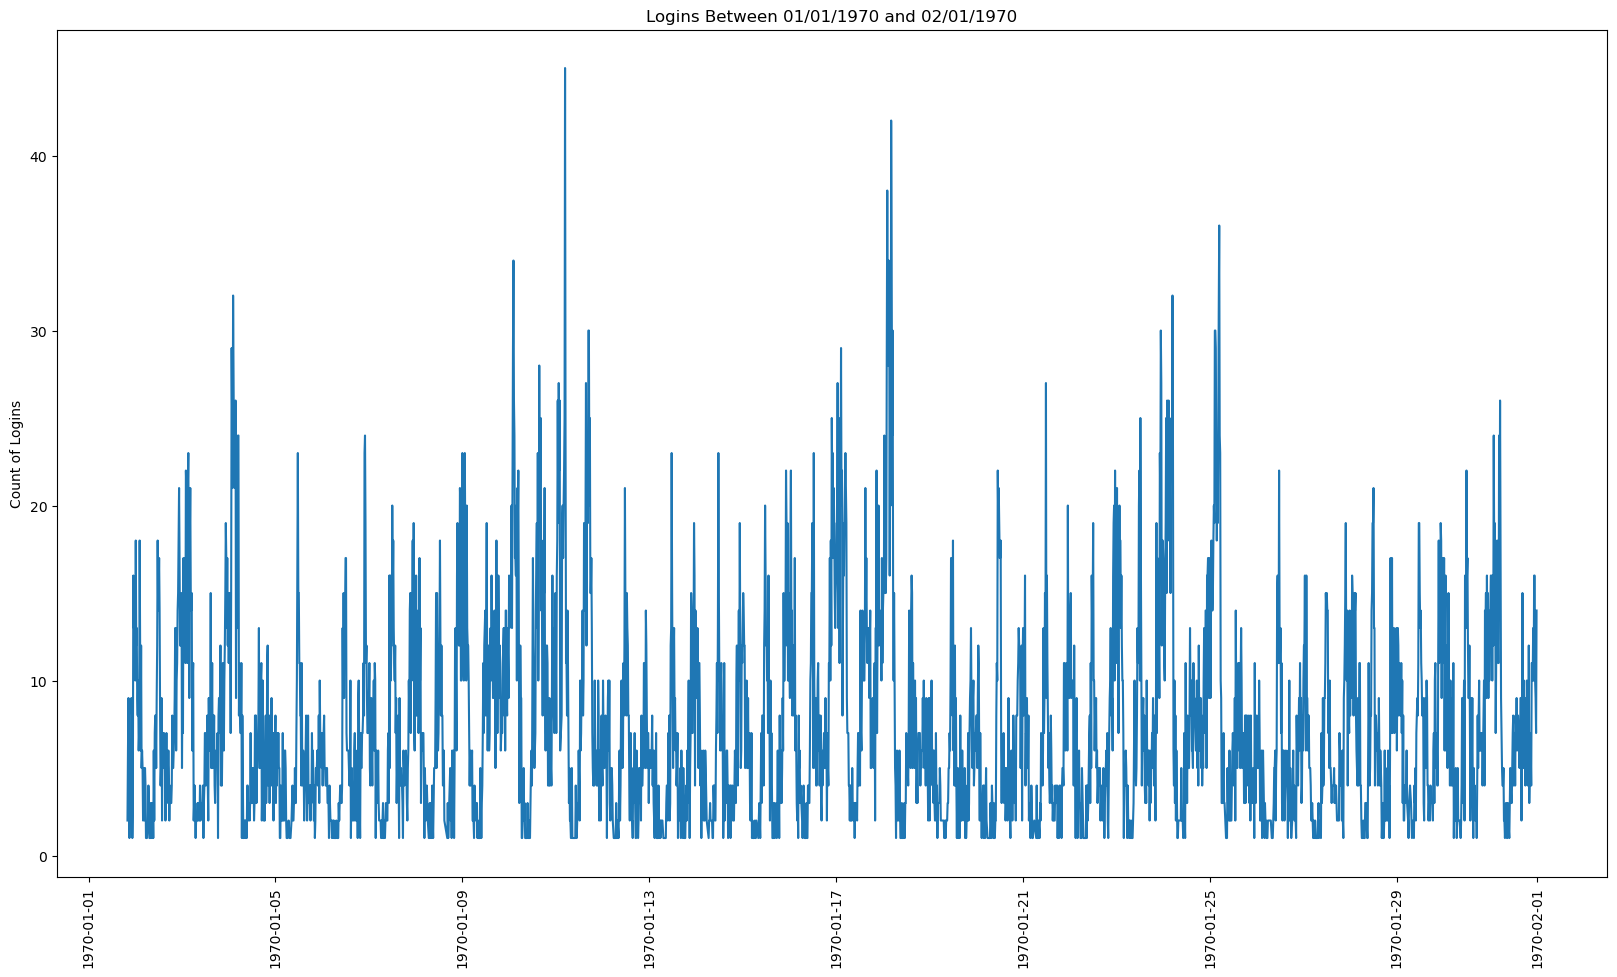

In [8]:
ax, fig = plt.subplots(figsize=(20,11))
_=plt.plot(y['1970-01-01':'1970-01-31'])
_=plt.xticks(rotation=90)
_=plt.ylabel('Count of Logins')
_=plt.title('Logins Between 01/01/1970 and 02/01/1970')

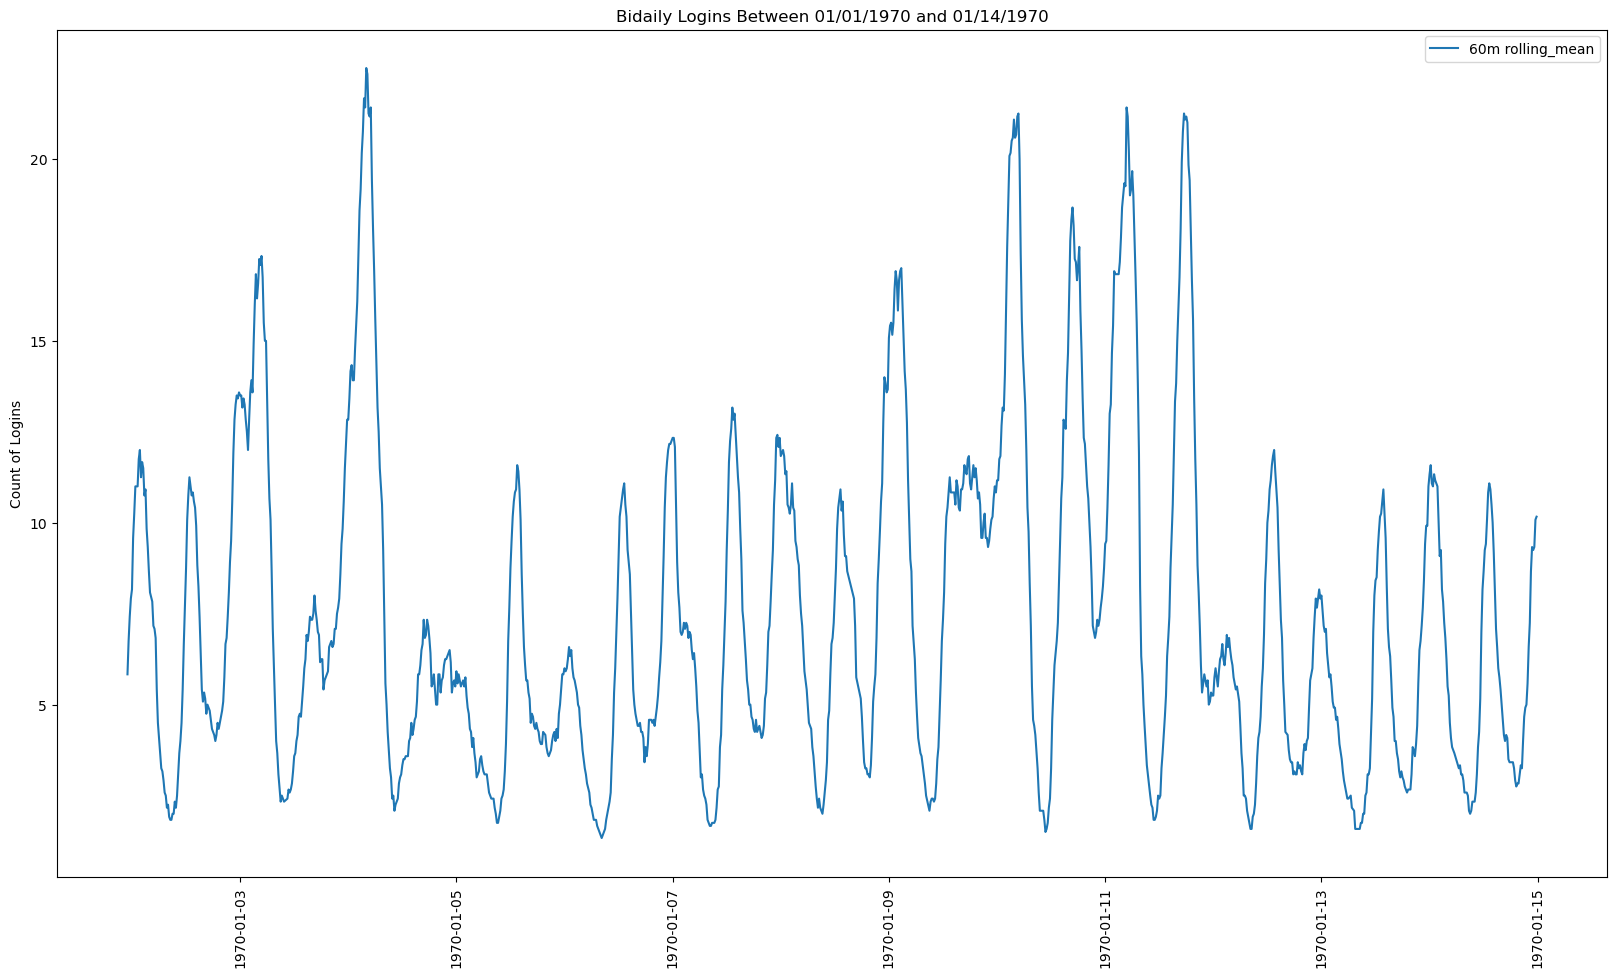

In [9]:
#Lets smooth those lines out with a 12 hour rolling mean
rolling_mean = y.rolling(window=12).mean()
ax, fig = plt.subplots(figsize=(20,11))
#_=plt.plot(y['1970-01-01':'1970-01-04'], label = '15m increments')
_=plt.plot(rolling_mean['1970-01-01':'1970-01-14'],label='60m rolling_mean')
_=plt.xticks(rotation=90)
_=plt.ylabel('Count of Logins')
_=plt.legend()
_=plt.title('Bidaily Logins Between 01/01/1970 and 01/14/1970')

By taking a 12 hour rolling mean, the data reviels a bidaily pattern. In this instance,users are most active in the middle of the night and noon with high levels of activities on weekends.  We are missing some data for our 15 minute windows. This is evident by the error messages recieved when trying to decompose the time series. 

# Part 2

The key metric for gauging the success of the program will be the total number of riders. This is because, by connecting the two cities, riders who commute between the cities can now use this service without paying the toll which may have prevented them from subscribing before.

<AxesSubplot:>

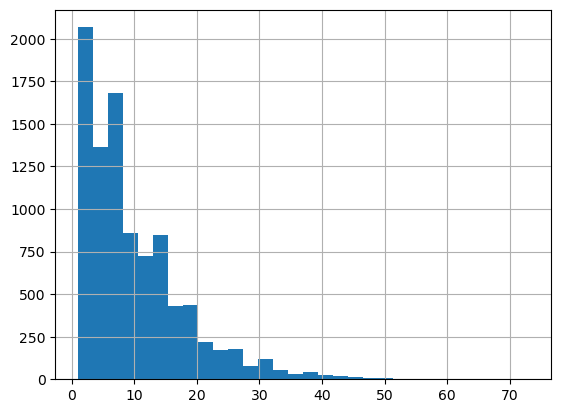

In [10]:
#is the data normal? 
y.hist(bins=30)

<AxesSubplot:>

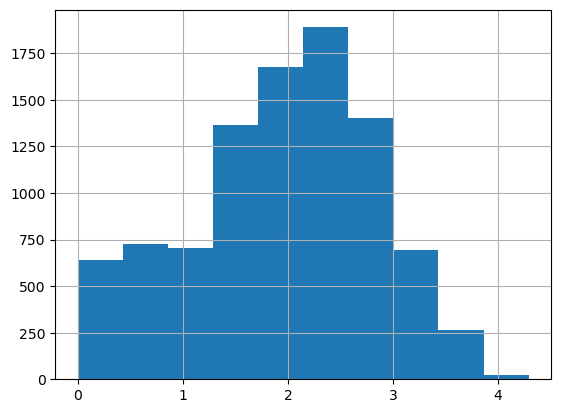

In [11]:
#is it normal if we log transform it? 
np.log(y).hist()

I will operate the program for 1 month to see if ridership increases. We can test the statistical significance of our intervention via a paired-t-test between our data before and after intervention. 

I will set our null hypothesis to: There is no descernable difference between the two datasets. 


I would want to see a p-value of less than 0.05 so that I can reject the Null hypothesis and make the claim that the intervention did have a meaningful impact on ridership. 

# Part 3

In [12]:
ultimate_data_challenge.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## A) Cleaning the Data

I need to:
 - check for nulls
 - check for data types
 - check for improperly inputed data (outliers)

In [13]:
ultimate_data_challenge.shape

(50000, 12)

In [35]:
#nulls
ultimate_data_challenge.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

#### null avg_rating_of_drivers

In [15]:
#lets first deal wtih avg_rating_of_driver
ultimate_data_challenge.avg_rating_of_driver.unique()

array([4.7, 5. , 4.3, 4.6, 4.4, 3.5, nan, 4.5, 4. , 3.9, 4.9, 4.8, 2.5,
       3.7, 1. , 4.1, 4.2, 3. , 3.8, 2. , 2.7, 3.3, 2.8, 3.6, 3.4, 3.2,
       2.6, 3.1, 2.9, 1.7, 1.8, 1.5, 2.3, 1.9, 2.1, 2.4, 1.6, 2.2])

Since the data is continueous, I will fill the nulls with the average value

In [16]:
#Find the mean rating
mean_rating = ultimate_data_challenge.avg_rating_of_driver.mean()

In [17]:
#fill in the null values with our mean rating
ultimate_data_challenge.avg_rating_of_driver.fillna(mean_rating, inplace=True)

#### null phone

In [18]:
ultimate_data_challenge.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [19]:
#what are the value counts
ultimate_data_challenge.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [22]:
#I will set phone nulls to "not provided" 
ultimate_data_challenge.phone.fillna('Not_Provided',inplace=True)

#### null 'avg_rating_by_driver'

In [26]:
ultimate_data_challenge.avg_rating_by_driver.unique()

array([5. , 4.9, 4. , 3. , 4.8, 4.7, 4.5, 4.2, nan, 4.4, 4.6, 3.7, 4.3,
       3.5, 2. , 3.8, 2.5, 4.1, 3.9, 1. , 3.3, 3.4, 3.6, 3.2, 2.3, 2.8,
       1.5, 2.7])

In [34]:
#we will fill in the nulls with the mean value
mean_rating_by_driver = ultimate_data_challenge.avg_rating_by_driver.mean()
ultimate_data_challenge.avg_rating_by_driver.fillna(mean_rating_by_driver,inplace=True)

#### Fix Data type

In [215]:
#set city to category
ultimate_data_challenge.city= ultimate_data_challenge.city.astype('category')
#set signup_date to datetime
ultimate_data_challenge.signup_date = pd.to_datetime(ultimate_data_challenge.signup_date)
#set phone to category
ultimate_data_challenge.phone = ultimate_data_challenge.phone.astype('category')

In [216]:
ultimate_data_challenge.dtypes

city                            category
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date                    object
phone                           category
surge_pct                        float64
ultimate_black_user                int64
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
retained                           int64
dtype: object

# EDA

In [36]:
ultimate_data_challenge.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [43]:
#first day of signup
ultimate_data_challenge.signup_date.min()

'2014-01-01'

In [42]:
#last date of a trip
ultimate_data_challenge.last_trip_date.max()

'2014-07-01'

This means that a ride will be considered retained if they took atleast 1 trip in June. 

In [54]:
#find the number of rows of retained riders
size_retained = ultimate_data_challenge.query("last_trip_date>='2014-06-01'").shape[0]

In [59]:
retained_percentage = round(size_retained/ultimate_data_challenge.shape[0],2) *100
print(f"{retained_percentage} percent of users took a trip within the preceding 30 days")

38.0 percent of users took a trip within the preceding 30 days


/Users/matt/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Counts of Riders in the Final Month')

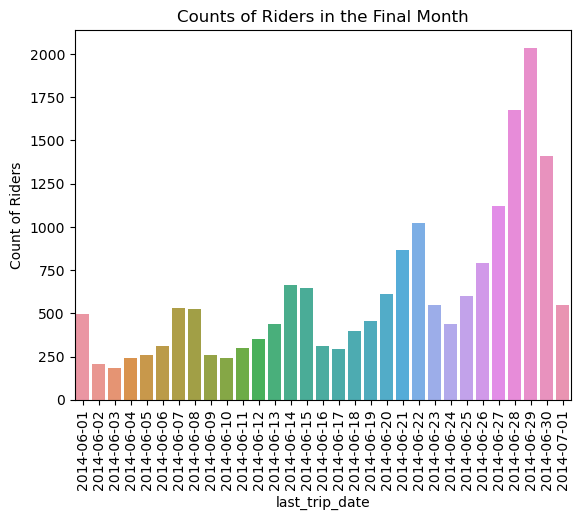

In [112]:
#graph of ride counts as of 6/1/2014
p = ultimate_data_challenge.query("last_trip_date>='2014-06-01'")\
            .sort_values('last_trip_date')\
            .last_trip_date
sns.countplot(p)
_=plt.xticks(rotation=90)
plt.ylabel('Count of Riders')
plt.title('Counts of Riders in the Final Month')

Looks like a good number of rides were taken on the 29th

Text(0.5, 1.0, 'Counts of Riders in the Final Month')

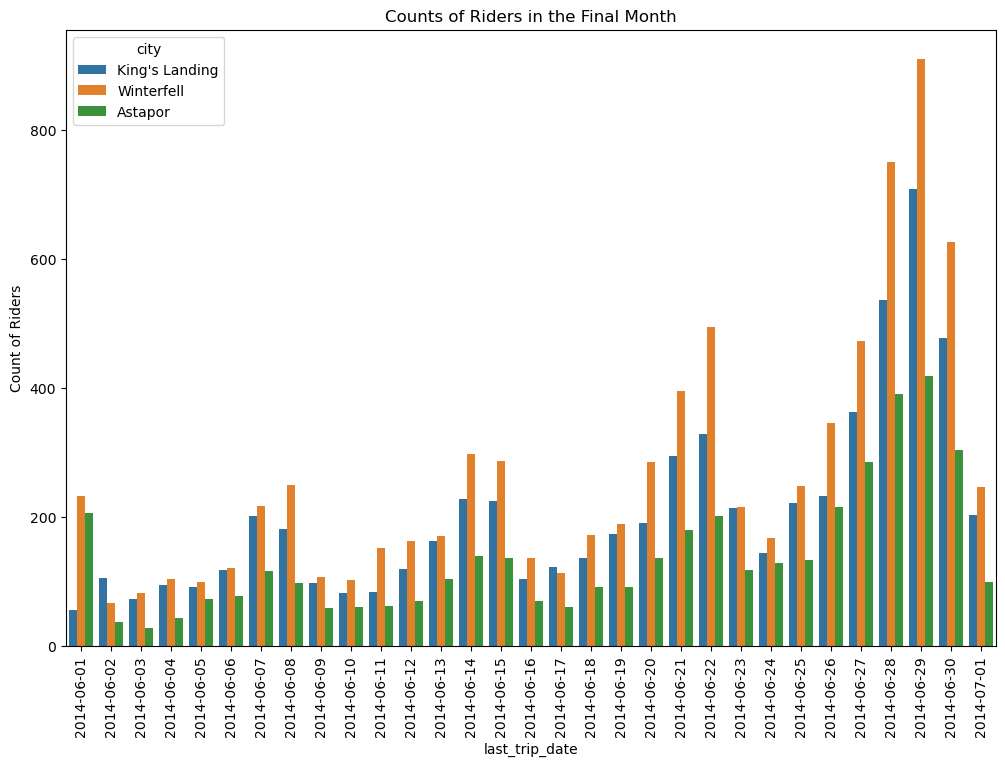

In [116]:
#I will add the city to the above graph
ax,fig = plt.subplots(figsize=(12,8))
p = ultimate_data_challenge.query("last_trip_date>='2014-06-01'")\
            .sort_values('last_trip_date')
sns.countplot(data=p,x='last_trip_date',hue='city')
_=plt.xticks(rotation=90)
plt.ylabel('Count of Riders')
plt.title('Counts of Riders in the Final Month')

Looks like weekend are bumping at Winterfell. It must have a great party scene

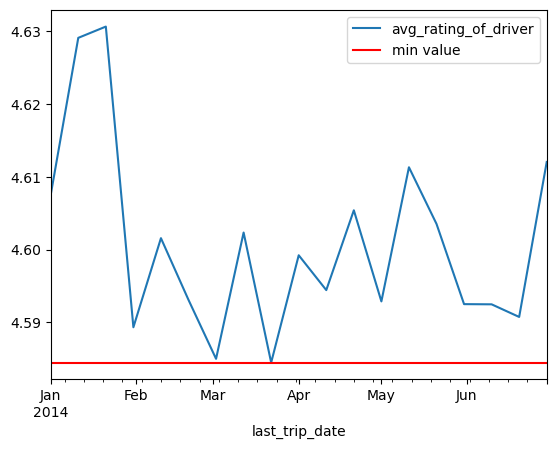

In [161]:
#did driver ratings decrease? 
# I will group into 10 day windows
df = ultimate_data_challenge[['avg_rating_of_driver','last_trip_date']]
df = df.set_index('last_trip_date')
df.index=pd.to_datetime(df.index)
# group the data into 10-day windows and calculate the mean of each window
result = df.resample('10D').mean()

result.plot()
plt.axhline(4.584476,color='r',linestyle='-',label='min value')
plt.legend()

Driver ratings changed minimally. Average values per a day day grouping never drop below 4.58.

# Feature Engineering

1. first we need to add a column for 'retained'

In [194]:
#create a list of retained users
list_of_retained_users =list(ultimate_data_challenge.query("last_trip_date>='2014-06-01'").index)

In [198]:
#for each retained user, add a 1 to the retained column, else 0

ultimate_data_challenge['retained'] =ultimate_data_challenge.apply \
    (lambda row : 1 if row.name in (list_of_retained_users) else 0 , axis=1) 

In [205]:
#set ultimate_black_user values to 1,0
ultimate_data_challenge.ultimate_black_user.replace({True:1,False:0},inplace=True)

In [221]:
#Since every signup date is from jan, we will convert the field into the day of jan
ultimate_data_challenge.signup_date = ultimate_data_challenge.signup_date.dt.day

In [225]:
#lastly, we will drop last_trip_date since we've capture that value in our retained field
df=ultimate_data_challenge.drop(columns='last_trip_date')

In [227]:
#Create our X and Y
X = df.drop(columns='retained')
y = df['retained']

In [232]:
#how imbalanced is our target?
y.value_counts()

0    31196
1    18804
Name: retained, dtype: int64

Do to this imbalance, I'll use smote to rebalance our target class

In [233]:
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.30, random_state=1)

In [236]:
#create unique lists for our different transformed columns
num_cols = list(X_train.select_dtypes(include='number').columns)
cat_cols = list(X_train.select_dtypes(include='category').columns)

#add the transformers
preprocessor = ColumnTransformer( 
    transformers = [
        ('num',StandardScaler(),num_cols),                         #scale the numerical values
        ('cat',OneHotEncoder(handle_unknown = 'ignore'),cat_cols)   #freq counts for words
    ], remainder='passthrough')

In [237]:
#fit and transform our data
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

In [251]:
#resample with smote to handle the class imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_res, y_res =smote.fit_resample(X_train_trans,y_train) 

In [266]:
#logistic Model
lr_model = LogisticRegression()
lr_model.fit(X_res,y_res)
y_pred = lr_model.predict(X_test_trans)

print("Logistic Regression")
print(classification_report(y_test,y_pred))

Logistic Regression
              precision    recall  f1-score   support

           0       0.78      0.71      0.74      9291
           1       0.59      0.67      0.63      5709

    accuracy                           0.70     15000
   macro avg       0.68      0.69      0.69     15000
weighted avg       0.71      0.70      0.70     15000



In [267]:
#random forest model 
rf_model = RandomForestClassifier()
rf_model.fit(X_res,y_res)
y_pred = rf_model.predict(X_test_trans)

print("Random Forest")
print(classification_report(y_test,y_pred))

Random Forest
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      9291
           1       0.70      0.68      0.69      5709

    accuracy                           0.77     15000
   macro avg       0.75      0.75      0.75     15000
weighted avg       0.77      0.77      0.77     15000



Here we can see that the random forest classifier performs better. I will now fine tune the model with hyper-parameters

In [262]:
#adding cross validation and hyperparamter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_res,y_res)

print(grid_search.best_params_)
print(grid_search.best_score_)


{'max_depth': 15, 'max_features': 'log2', 'n_estimators': 500}
0.8160693905501027


In [268]:
#print out eval metrics for this best model 
rf_best = RandomForestClassifier(**grid_search.best_params_)
rf_best.fit(X_res,y_res)
y_pred = rf_best.predict(X_test_trans)

print("Random Forest")
print(classification_report(y_test,y_pred))

Random Forest
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      9291
           1       0.71      0.71      0.71      5709

    accuracy                           0.78     15000
   macro avg       0.77      0.77      0.77     15000
weighted avg       0.78      0.78      0.78     15000



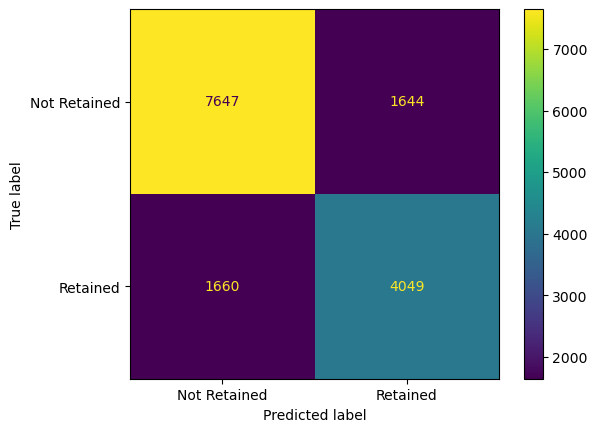

In [292]:
#print a confusion Matrix
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Not Retained','Retained'])
disp.plot()
plt.show()

# Find the Most Important Features

In [ ]:
selector = RFECV(rf_best, step=1, cv=3,
              scoring='f1')

selector.fit(X_res,y_res)

plt.plot(range(len(selector.grid_scores_)),selector.grid_scores_)
plt.title('Number of features and F1 Scores')
plt.xlabel("# features")
plt.ylabel('f1 score')

Looks like 10 feature are ideal

In [ ]:
#Recursive Feature Elimination
selector = RFE(lr_model, n_features_to_select=1)
selector.fit(X_res,y_res)

In [300]:
RFE_df = pd.DataFrame(preprocessor.get_feature_names_out(),selector.ranking_)
RFE_df.reset_index(inplace=True)
RFE_df = pd.concat([RFE_df,pd.DataFrame(selector.estimator.coef_[0])],axis=1)
RFE_df.columns=['Rank','Features','Coef']
# RFE_df =RFE_df.loc[RFE_df.Rank==1][['Features','Coef']]
# RFE_df = RFE_df.loc[RFE_df.Coef>0].sort_values('Coef',ascending=False)
# RFE_df.columns = pd.MultiIndex.from_product([["RFE"], RFE_df.columns])
RFE_df.sort_values('Rank')

,Rank,Features,Coef
10,1,cat__city_King's Landing,0.940681
14,2,cat__phone_iPhone,0.587112
0,3,num__trips_in_first_30_days,0.454867
9,4,cat__city_Astapor,-0.778316
11,5,cat__city_Winterfell,-0.295432
5,6,num__ultimate_black_user,0.421712
12,7,cat__phone_Android,-0.533835
7,8,num__avg_dist,-0.242256
13,9,cat__phone_Not_Provided,-0.186343
8,10,num__avg_rating_by_driver,-0.056391


From this output, we can see that the features that push users to retain the service are iphone users, who took a lot of trips in first 30 days and are traveling to King's Landing. Conversely, users that did not retain service are heading to Astrapor and Winterfell and are android users.

In [313]:
#does king's landing have more iphones?
df.groupby('city')['phone'].value_counts()

city                        
Astapor         iPhone          11169
                Android          5244
                Not_Provided      121
King's Landing  iPhone           7568
                Android          2498
                Not_Provided       64
Winterfell      iPhone          15845
                Android          7280
                Not_Provided      211
Name: phone, dtype: int64

In [315]:
#does king's landing have more ultimate_black_users?
df.groupby('city')['ultimate_black_user'].value_counts()

city            ultimate_black_user
Astapor         0                      10057
                1                       6477
King's Landing  0                       5924
                1                       4206
Winterfell      0                      15165
                1                       8171
Name: ultimate_black_user, dtype: int64

# Final Insight

I created a random forest model to help Ultimate predict whether a user would retain the service by analyzing 50,000 data containing information such as trip location, phone type, average distance traveled, driver ratings and more. Additionally I created a list of most impactful features that either increase or decrease likelihood that a user would retain the service.

My advice, to help Ultimate retain more users, is to do further analysis as to why users who are traveling to Winterfell and Astapor are much more likely to drop the service than those in King's Landing. It also looks like Android users are inversely likely to drop the service as iphone users are to retain it. Perhaps some work on the android app needs to commense. Additionally, ultimate black users are more likely to retain the service and there is a more equal proportion of ultimate black users to non-users in Winterfell than the other cities. This would be another thing I'd recommend to investigate. 
